In [1]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # conda install opencv
import re
from sklearn import preprocessing
import scipy.ndimage as ndimage
import scipy.interpolate as interpolate
#basedir = '/Users/Nick/Documents/MATLAB/Rao Lab/normalized_data/'
# load data and labels
import file_structure

def zoompad(array, desired_size):
    array = cv2.resize(array,(desired_size[0],desired_size[1]))
    return array

(origdir,basedir,imagedir,normdir,savedir) = file_structure.file_dirs()

os.chdir(imagedir)

#patients=next(os.walk('.'))[1]
p_dirs = []
patients = []
for root, dirs, files in os.walk('.'):
    for dn in dirs:
        patients.append(dn)
        p_dirs.append(os.path.join(root,dn))


# obtain top 50 percentile images

#Load a spreadsheet with patient ID in the first column, age in the third column, and IDH status in the second column
#xl = pd.ExcelFile('/Users/Nick/Documents/MATLAB/Rao Lab/clinical_data_IDH1_1p19q.xlsx')
xl = pd.ExcelFile(os.path.join(basedir,'data','clinical_data_v2.xlsx'))
df = np.asarray(xl.parse("S1A. TCGA discovery dataset"))
#pIdxs =np.arange(np.asarray(df[:,0]).shape[0])[np.in1d(df[:,0],patients)]
pMask = np.in1d(df[:,0],patients)
#print(df)
#print(df[:,0])
#print(patients)
#print(np.intersect1d(df[:,0],patients))
#print(pIdxs)
dfFilt = df[pMask,:] # filter out the rows of the excel file that don't have imaging information

dirIdxs =np.arange(np.asarray(patients).shape[0])[np.in1d(patients,df[:,0])] # filter out the directories 

patients = [patients[i] for i in dirIdxs] # lists have to be handled differently
p_dirs = [p_dirs[i] for i in dirIdxs] 

#print(dfFilt)
patient_age = dfFilt[:,[0,14]]
patient_IDH = dfFilt[:,[0,21]]
patient_1p19q = dfFilt[:,[0,22]]
patient_IDH1_1p19q = dfFilt[:,[0,23]]
patient_OS = dfFilt[:,[0,16]]
patient_gender = dfFilt[:,[0,15]]
patient_KPS = dfFilt[:,[0,18]]
kps_mask = pd.isnull(patient_KPS[:,1])
patient_KPS[kps_mask,1] = 80 # impute KPS when nan to 80
                                 
print(patient_1p19q[:,1])

C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0
 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [2]:
desired_size=[142,142]

# obtain the ratio between codel and non_codel
nn_patient_1p19q = patient_1p19q[~pd.isnull(patient_1p19q[:,1]),:]
num_codel = np.count_nonzero(nn_patient_1p19q[:,1])
num_non_codel = len(nn_patient_1p19q[:,1])- num_codel
print(num_codel)
print(num_non_codel)
#codel: non_codel = 13:130 = 1:10

# for balancing purpose between codel vs non-codel cases, extract 30 codel per 3 non-codel case => 50:50

# pre allocate arrays for codel and non codel separately

# case: non-codel 130*3 = 390

non_codel_factor = 2


slices_FLAIR = np.empty([num_non_codel*non_codel_factor, desired_size[0], desired_size[1], 3])
slices_T2 = np.empty([num_non_codel*non_codel_factor, desired_size[0], desired_size[1], 3])
slices_T1 = np.empty([num_non_codel*non_codel_factor, desired_size[0], desired_size[1], 3])
slices_T1post = np.empty([num_non_codel*non_codel_factor, desired_size[0], desired_size[1], 3])
slices_mask = np.empty([num_non_codel*non_codel_factor, desired_size[0], desired_size[1], 3])

label_age = np.empty(num_non_codel*non_codel_factor)
label_IDH1 = np.empty(num_non_codel*non_codel_factor)
label_1p19q = np.empty(num_non_codel*non_codel_factor)
label_IDH1_1p19q = np.empty(num_non_codel*non_codel_factor)
label_OS = np.empty(num_non_codel*non_codel_factor)
label_gender = np.empty(num_non_codel*non_codel_factor)
label_KPS = np.empty(num_non_codel*non_codel_factor) 
label_id = np.empty(num_non_codel*non_codel_factor) 
label_idstr = np.empty(num_non_codel*non_codel_factor,dtype=object) 
print(label_gender.shape)
print(num_non_codel*non_codel_factor)

13
130
(260,)
260


In [3]:
codel_factor = 20

slices_FLAIR_codel = np.empty([num_codel*codel_factor, desired_size[0], desired_size[1], 3])
slices_T2_codel = np.empty([num_codel*codel_factor, desired_size[0], desired_size[1], 3])
slices_T1_codel = np.empty([num_codel*codel_factor, desired_size[0], desired_size[1], 3])
slices_T1post_codel = np.empty([num_codel*codel_factor, desired_size[0], desired_size[1], 3])
slices_mask_codel = np.empty([num_non_codel*non_codel_factor, desired_size[0], desired_size[1], 3])

label_age_codel = np.empty(num_codel*codel_factor)
label_IDH1_codel = np.empty(num_codel*codel_factor)
label_1p19q_codel = np.empty(num_codel*codel_factor)
label_IDH1_1p19q_codel = np.empty(num_codel*codel_factor)
label_OS_codel = np.empty(num_codel*codel_factor)
label_gender_codel = np.empty(num_codel*codel_factor)
label_KPS_codel = np.empty(num_codel*codel_factor) 
label_id_codel = np.empty(num_codel*codel_factor) 
label_idstr_codel = np.empty(num_codel*codel_factor,dtype=object) 




In [4]:
#counters
codel_counter = 0
non_codel_counter = 0
used_sl_idx_arr = np.empty((0,1))
#for p in range(3):#range(len(patients)):
for p in range(len(patients)):
    #p_bdir = os.path.basename(patients[p])
    #p_bdir = patients[p]
    #p_id = p_bdir # new set matches IDs, though some transformation may be needed in the future
    p_id = patients[p]
    patient_dir = os.path.join(normdir,p_dirs[p])

    print(p, p_id,patient_dir)
    idx_idh1=np.asarray(np.where((patient_IDH[:,0].astype(str))==str(p_id)))
    if (idx_idh1.size == 0): # not found in the spreadsheet
        print("\"%s\" not found in Excel Spreadsheet" % (p_id))
        continue # skip this folder
    
    curr_idh1 = patient_IDH[idx_idh1,1]
    if curr_idh1 == 'WT':
        curr_idh1 = 0
    elif curr_idh1 == 'Mutant':
        curr_idh1 = 1
    elif not (curr_idh1 == 1 or curr_idh1 == 0):
        curr_idh1 = float('nan')

    idx_age=np.asarray(np.where((patient_age[:,0].astype(str))==str(p_id)))
    curr_age = patient_age[idx_age,1]

    idx_1p19q=np.asarray(np.where((patient_1p19q[:,0].astype(str))==str(p_id)))
    curr_1p19q = patient_1p19q[idx_1p19q,1]

    idx_IDH1_1p19q=np.asarray(np.where((patient_IDH1_1p19q[:,0].astype(str))==str(p_id)))
    curr_IDH1_1p19q = patient_IDH1_1p19q[idx_IDH1_1p19q,1]
    if curr_IDH1_1p19q == 'IDHwt':
        curr_IDH1_1p19q = 0
    elif curr_IDH1_1p19q == 'IDHmut-non-codel':
        curr_IDH1_1p19q = 1
    elif curr_IDH1_1p19q == 'IDHmut-codel':
        curr_IDH1_1p19q = 2
    elif not (curr_IDH1_1p19q == 1 or curr_IDH1_1p19q == 0):
        curr_IDH1_1p19q = float('nan')

    idx_OS=np.asarray(np.where((patient_OS[:,0].astype(str))==str(p_id)))
    curr_OS = patient_OS[idx_OS,1]

    idx_gender=np.asarray(np.where((patient_gender[:,0].astype(str))==str(p_id)))
    input_gender=patient_gender[idx_gender,1] # if handling a string, and you put in a float, things get ugly when you delete
    if input_gender == 'male':
        curr_gender = np.float64(0)
    elif input_gender == 'female':
        curr_gender = np.float64(1)
    elif not (input_gender == 1 or input_gender == 0):
        curr_gender = float('nan')
        #print('nan')
    else:
        curr_gender = input_gender
    
    if not (curr_gender == 1 or curr_gender == 0):
        print(curr_gender)
    idx_KPS=np.asarray(np.where((patient_KPS[:,0].astype(str))==str(p_id)))
    curr_KPS=patient_KPS[idx_KPS,1]

    os.chdir(patient_dir)
    FLAIR = np.load('FLAIR_normssn4.npy')
    T2 = np.load('T2_normssn4.npy')
    T1 = np.load('T1_normssn4.npy')
    T1post = np.load('T1post_normssn4.npy')
    mask = np.load('truth.npy')

    #FLAIR = nib.load('flair.nii.gz').get_data()
    #T2 = nib.load('t2.nii.gz').get_data()
    #T1 = nib.load('t1.nii.gz').get_data()
    #T1post = nib.load('t1Gd.nii.gz').get_data()
    #mask = nib.load('truth.nii.gz').get_data()

    # mask label is organized as following: 1 = non-enhancing, 2 = edema, 4 = enhancing 
    mask[mask==2] = 1
    mask[mask==4] = 1

    FLAIR_m= FLAIR
    T2_m= T2
    T1_m= T1
    T1post_m= T1post

    #Find the largest, 75th, and 50th percentile slices in each dimension
    x_sum=np.sum(mask,axis=(1,2))
    y_sum=np.sum(mask,axis=(0,2))
    z_sum=np.sum(mask,axis=(0,1))

    #Check if the patient is codel or non-codel (1 or 0). The ratio between codel and non-codel is 13:130
    #So, subsample codel cases 10 times more than codel

    if curr_1p19q == 0: #i.e. if non-codel case, subsample 100,75, and 50 percentile

        xp100=np.percentile(x_sum[np.nonzero(x_sum)],100,interpolation='nearest')
        xp75=np.percentile(x_sum[np.nonzero(x_sum)],75,interpolation='nearest')
        # xp50=np.percentile(x_ m[np.nonzero(x_sum)],50,interpolation='nearest')
        yp100=np.percentile(y_sum[np.nonzero(y_sum)],100,interpolation='nearest')
        yp75=np.percentile(y_sum[np.nonzero(y_sum)],75,interpolation='nearest')
        # yp50=np.percentile(y_sum[np.nonzero(y_sum)],50,interpolation='nearest')
        zp100=np.percentile(z_sum[np.nonzero(z_sum)],100,interpolation='nearest')
        zp75=np.percentile(z_sum[np.nonzero(z_sum)],75,interpolation='nearest')
        # zp50=np.percentile(z_sum[np.nonzero(z_sum)],50,interpolation='nearest')

        x_idx = np.argwhere(x_sum==xp100)[0][0]
        y_idx = np.argwhere(y_sum==yp100)[0][0]
        z_idx = np.argwhere(z_sum==zp100)[0][0]

        B = np.argwhere(mask[x_idx])
        (xstart_x, ystart_x), (xstop_x, ystop_x) = B.min(0), B.max(0) + 1     
        B = np.argwhere(mask[:,y_idx])
        (xstart_y, ystart_y), (xstop_y, ystop_y) = B.min(0), B.max(0) + 1     
        B = np.argwhere(mask[:,:,z_idx])
        (xstart_z, ystart_z), (xstop_z, ystop_z) = B.min(0), B.max(0) + 1

        FLAIR_x1 = zoompad(np.asarray(FLAIR_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        FLAIR_y1 = zoompad(np.asarray(FLAIR_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        FLAIR_z1 = zoompad(np.asarray(FLAIR_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

        T2_x1 = zoompad(np.asarray(T2_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        T2_y1 = zoompad(np.asarray(T2_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        T2_z1 = zoompad(np.asarray(T2_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

        T1_x1 = zoompad(np.asarray(T1_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        T1_y1 = zoompad(np.asarray(T1_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        T1_z1 = zoompad(np.asarray(T1_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

        T1post_x1 = zoompad(np.asarray(T1post_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        T1post_y1 = zoompad(np.asarray(T1post_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        T1post_z1 = zoompad(np.asarray(T1post_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)
        
        mask_x1 = zoompad(np.asarray(mask[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        mask_y1 = zoompad(np.asarray(mask[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        mask_z1 = zoompad(np.asarray(mask[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

        x_idx = np.argwhere(x_sum==xp75)[0][0]
        y_idx = np.argwhere(y_sum==yp75)[0][0]
        z_idx = np.argwhere(z_sum==zp75)[0][0]

        B = np.argwhere(mask[x_idx])
        (xstart_x, ystart_x), (xstop_x, ystop_x) = B.min(0), B.max(0) + 1     
        B = np.argwhere(mask[:,y_idx])
        (xstart_y, ystart_y), (xstop_y, ystop_y) = B.min(0), B.max(0) + 1     
        B = np.argwhere(mask[:,:,z_idx])
        (xstart_z, ystart_z), (xstop_z, ystop_z) = B.min(0), B.max(0) + 1

        FLAIR_x2 = zoompad(np.asarray(FLAIR_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        FLAIR_y2 = zoompad(np.asarray(FLAIR_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        FLAIR_z2 = zoompad(np.asarray(FLAIR_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

        T2_x2 = zoompad(np.asarray(T2_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        T2_y2 = zoompad(np.asarray(T2_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        T2_z2 = zoompad(np.asarray(T2_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

        T1_x2 = zoompad(np.asarray(T1_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        T1_y2 = zoompad(np.asarray(T1_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        T1_z2 = zoompad(np.asarray(T1_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

        T1post_x2 = zoompad(np.asarray(T1post_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        T1post_y2 = zoompad(np.asarray(T1post_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        T1post_z2 = zoompad(np.asarray(T1post_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)
        
        mask_x2 = zoompad(np.asarray(mask[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
        mask_y2 = zoompad(np.asarray(mask[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
        mask_z2 = zoompad(np.asarray(mask[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

        # save in ascending order
        slices_FLAIR[non_codel_factor*non_codel_counter] = np.stack((FLAIR_x2, FLAIR_y2, FLAIR_z2), axis=2)
        slices_FLAIR[non_codel_factor*non_codel_counter+1] = np.stack((FLAIR_x1, FLAIR_y1, FLAIR_z1), axis=2)

        slices_T2[non_codel_factor*non_codel_counter] = np.stack((T2_x2, T2_y2, T2_z2), axis=2)
        slices_T2[non_codel_factor*non_codel_counter+1] = np.stack((T2_x1, T2_y1, T2_z1), axis=2)

        slices_T1[non_codel_factor*non_codel_counter] = np.stack((T1_x2, T1_y2, T1_z2), axis=2)
        slices_T1[non_codel_factor*non_codel_counter+1] = np.stack((T1_x1, T1_y1, T1_z1), axis=2)

        slices_T1post[non_codel_factor*non_codel_counter] = np.stack((T1post_y2, T1post_y2, T1post_z2), axis=2)
        slices_T1post[non_codel_factor*non_codel_counter+1] = np.stack((T1post_x1, T1post_y1, T1post_z1), axis=2)
        
        slices_mask[non_codel_factor*non_codel_counter] = np.stack((mask_y2, mask_y2, mask_z2), axis=2)
        slices_mask[non_codel_factor*non_codel_counter+1] = np.stack((mask_x1, mask_y1, mask_z1), axis=2)

        label_age[non_codel_factor*non_codel_counter:non_codel_factor*non_codel_counter+non_codel_factor] = curr_age
        label_IDH1[non_codel_factor*non_codel_counter:non_codel_factor*non_codel_counter+non_codel_factor] = curr_idh1
        label_1p19q[non_codel_factor*non_codel_counter:non_codel_factor*non_codel_counter+non_codel_factor] = curr_1p19q
        label_IDH1_1p19q[non_codel_factor*non_codel_counter:non_codel_factor*non_codel_counter+non_codel_factor] = curr_IDH1_1p19q
        label_OS[non_codel_factor*non_codel_counter:non_codel_factor*non_codel_counter+non_codel_factor] = curr_OS
        label_gender[non_codel_factor*non_codel_counter:non_codel_factor*non_codel_counter+non_codel_factor] = curr_gender
        label_KPS[non_codel_factor*non_codel_counter:non_codel_factor*non_codel_counter+non_codel_factor] = curr_KPS
        label_id[non_codel_factor*non_codel_counter:non_codel_factor*non_codel_counter+non_codel_factor] = p
        label_idstr[non_codel_factor*non_codel_counter:non_codel_factor*non_codel_counter+non_codel_factor] = patients[p]
        
        non_codel_counter += 1

    elif curr_1p19q == 1:
        #obtain top 30 mask area indices
        x_ind_array = np.argpartition(x_sum,-codel_factor)[-codel_factor:]
        x_ind_array = x_ind_array[np.argsort(x_sum[x_ind_array])]

        y_ind_array = np.argpartition(y_sum,-codel_factor)[-codel_factor:]
        y_ind_array = y_ind_array[np.argsort(y_sum[y_ind_array])]

        z_ind_array = np.argpartition(z_sum,-codel_factor)[-codel_factor:]
        z_ind_array = z_ind_array[np.argsort(z_sum[z_ind_array])]

        for slice_ind in range(codel_factor): # store in ascending order

            x_idx = x_ind_array[slice_ind]
            y_idx = y_ind_array[slice_ind]
            z_idx = z_ind_array[slice_ind]

            B = np.argwhere(mask[x_idx]) # y-z plane
            (xstart_x, ystart_x), (xstop_x, ystop_x) = B.min(0), B.max(0) + 1 
            B = np.argwhere(mask[:,y_idx]) # x-z plane
            (xstart_y, ystart_y), (xstop_y, ystop_y) = B.min(0), B.max(0) + 1 
            B = np.argwhere(mask[:,:,z_idx]) # x-y plane
            (xstart_z, ystart_z), (xstop_z, ystop_z) = B.min(0), B.max(0) + 1

            FLAIR_x = zoompad(np.asarray(FLAIR_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
            FLAIR_y = zoompad(np.asarray(FLAIR_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
            FLAIR_z = zoompad(np.asarray(FLAIR_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

            T2_x = zoompad(np.asarray(T2_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
            T2_y = zoompad(np.asarray(T2_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
            T2_z = zoompad(np.asarray(T2_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

            T1_x = zoompad(np.asarray(T1_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
            T1_y = zoompad(np.asarray(T1_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
            T1_z = zoompad(np.asarray(T1_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

            T1post_x = zoompad(np.asarray(T1post_m[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
            T1post_y = zoompad(np.asarray(T1post_m[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
            T1post_z = zoompad(np.asarray(T1post_m[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)
            
            mask_x = zoompad(np.asarray(mask[x_idx][xstart_x:xstop_x, ystart_x:ystop_x]), desired_size)
            mask_y = zoompad(np.asarray(mask[:,y_idx][xstart_y:xstop_y, ystart_y:ystop_y]), desired_size)
            mask_z = zoompad(np.asarray(mask[:,:,z_idx][xstart_z:xstop_z, ystart_z:ystop_z]), desired_size)

            slices_FLAIR_codel[codel_factor*codel_counter + slice_ind] = np.stack((FLAIR_x, FLAIR_y, FLAIR_z), axis=2)
            slices_T2_codel[codel_factor*codel_counter + slice_ind] = np.stack((T2_x, T2_y, T2_z), axis=2)
            slices_T1_codel[codel_factor*codel_counter + slice_ind] = np.stack((T1_x, T1_y, T1_z), axis=2)
            slices_T1post_codel[codel_factor*codel_counter + slice_ind] = np.stack((T1post_x, T1post_y, T1post_z), axis=2)
            slices_mask_codel[codel_factor*codel_counter + slice_ind] = np.stack((mask_x, mask_y, mask_z), axis=2)
            used_sl_idx_arr = np.append(used_sl_idx_arr,y_idx)
        print("Done saving 20 slices")


        label_age_codel[codel_factor*codel_counter:codel_factor*codel_counter+codel_factor] = curr_age
        label_IDH1_codel[codel_factor*codel_counter:codel_factor*codel_counter+codel_factor] = curr_idh1
        label_1p19q_codel[codel_factor*codel_counter:codel_factor*codel_counter+codel_factor] = curr_1p19q
        label_IDH1_1p19q_codel[codel_factor*codel_counter:codel_factor*codel_counter+codel_factor] = curr_IDH1_1p19q
        label_OS_codel[codel_factor*codel_counter:codel_factor*codel_counter+codel_factor] = curr_OS
        label_gender_codel[codel_factor*codel_counter:codel_factor*codel_counter+codel_factor] = curr_gender
        label_KPS_codel[codel_factor*codel_counter:codel_factor*codel_counter+codel_factor] = curr_KPS
        label_id_codel[codel_factor*codel_counter:codel_factor*codel_counter+codel_factor] = p
        label_idstr_codel[codel_factor*codel_counter:codel_factor*codel_counter+codel_factor] = patients[p]
        
        codel_counter += 1

    print("Done patient number: ", p)
    del FLAIR, T2, T1, T1post, mask, curr_age, curr_idh1, curr_1p19q, curr_IDH1_1p19q, curr_OS, curr_KPS,curr_gender


0 TCGA-02-0006 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0006
Done patient number:  0
1 TCGA-02-0009 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0009
Done patient number:  1
2 TCGA-02-0011 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0011
Done patient number:  2
3 TCGA-02-0027 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0027
Done patient number:  3
4 TCGA-02-0033 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0033
Done patient number:  4
5 TCGA-02-0034 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0034
Done patient number:  5
6 TCGA-02-0037 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0037
Done patient number:  6
7 TCGA-02-0046 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0046
Done patient number:  7
8 TCGA-02-0047 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0047
Done patient num

Done patient number:  72
73 TCGA-76-6656 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6656
Done patient number:  73
74 TCGA-76-6657 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6657
Done patient number:  74
75 TCGA-76-6661 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6661
Done patient number:  75
76 TCGA-76-6662 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6662
Done patient number:  76
77 TCGA-76-6663 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6663
Done patient number:  77
78 TCGA-76-6664 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6664
Done patient number:  78
79 TCGA-CS-4942 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-CS-4942
Done patient number:  79
80 TCGA-CS-4944 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-CS-4944
Done patient number:  80
81 TCGA-CS-5393 C:\Users\ncwang\Box\1p19q Project\data\normaliz

Done patient number:  141
142 TCGA-HT-A61A C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-HT-A61A
Done patient number:  142


In [5]:
print(used_sl_idx_arr)

[108. 107.  89. 106.  90. 105.  91. 104.  92.  93.  94. 103.  95.  96.
 102.  97.  98. 101.  99. 100. 118. 117. 116.  99. 115. 100. 114. 113.
 101. 112. 111. 102. 110. 108. 109. 107. 103. 106. 105. 104.  65.  84.
  66.  67.  68.  69.  83.  70.  72.  82.  73.  71.  74.  80.  81.  76.
  75.  79.  78.  77.  92. 111.  93.  94.  95. 110.  96. 109.  97.  98.
 108.  99. 102. 105. 106. 104. 107. 100. 101. 103. 114. 113.  95.  96.
  97. 112.  98. 111.  99. 110. 100. 101. 109. 102. 103. 108. 104. 107.
 105. 106.  71. 100.  70.  99.  72.  68.  76.  73.  74.  58.  67.  75.
  66.  59.  60.  65.  61.  64.  63.  62.  86. 104. 105.  87.  88. 103.
 102. 101. 100.  99.  98.  89.  97.  96.  95.  94.  90.  93.  92.  91.
 109.  90.  95.  94.  93. 108.  91.  92. 107.  96.  97. 105. 106. 104.
 103. 102.  98. 101.  99. 100. 115.  96. 114.  97. 113.  98. 112. 108.
  99. 109. 110. 111. 107. 100. 106. 101. 105. 102. 104. 103. 103.  84.
  85. 102.  86. 101.  87. 100.  93.  99.  92.  88.  94.  91.  98.  89.
  95. 

In [6]:
# Combine codel and non-codel together
slices_FLAIR_comb = np.vstack((slices_FLAIR,slices_FLAIR_codel))
slices_T1_comb = np.vstack((slices_T1,slices_T1_codel))
slices_T1post_comb = np.vstack((slices_T1post,slices_T1post_codel))
slices_T2_comb = np.vstack((slices_T2,slices_T2_codel))
slices_mask_comb = np.vstack((slices_mask,slices_mask_codel))

label_age_comb = np.append(label_age, label_age_codel)
label_IDH1_comb = np.append(label_IDH1,label_IDH1_codel)
label_1p19q_comb = np.append(label_1p19q,label_1p19q_codel)
label_gender_comb = np.append(label_gender, label_gender_codel)
label_KPS_comb = np.append(label_KPS, label_KPS_codel)
label_OS_comb = np.append(label_OS, label_OS_codel)
label_IDH1_1p19q_comb = np.append(label_IDH1_1p19q, label_IDH1_1p19q_codel)
label_id_comb = np.append(label_id, label_id_codel)
label_idstr_comb = np.append(label_idstr, label_idstr_codel)




#os.chdir(savedir)
os.chdir(savedir)
np.save('slices_FLAIR.npy', slices_FLAIR_comb)
np.save('slices_T2.npy', slices_T2_comb)
np.save('slices_T1.npy', slices_T1_comb)
np.save('slices_T1post.npy', slices_T1post_comb)
np.save('slices_mask.npy', slices_mask_comb)

np.save('label_age.npy',label_age_comb)
np.save('label_IDH1.npy', label_IDH1_comb)
np.save('label_1p19q.npy', label_1p19q_comb)
np.save('label_IDH1_1p19q.npy', label_IDH1_1p19q_comb)
np.save('label_OS.npy', label_OS_comb)
np.save('label_gender.npy', label_gender_comb)
np.save('label_KPS.npy', label_KPS_comb)
np.save('label_id.npy', label_id_comb)
np.save('label_idstr.npy', label_idstr_comb)
np.savetxt('label_idstr.csv', label_idstr_comb,delimiter=',',fmt='%s')

In [7]:
# fixed version of the slice selection
# expands the images for later perturbation analysis


modal_list = ['FLAIR','T1', 'T1post','T2']
slices = {}
codel_factor = 20
desired_size=[142,142]
exp_c = .5 # expansion coefficient on each side of the image
exp_size = [np.int(sz*(1+(exp_c*2))) for sz in desired_size] #[284, 284] for 50% expansion

codel_slices = num_codel*codel_factor 
noncodel_slices = num_non_codel*non_codel_factor
total_slices = codel_slices + noncodel_slices
exp_slice_dict = {}
exp_mask_arr = np.empty((total_slices,exp_size[0],exp_size[1],3))
for modal in modal_list:
    exp_slice_dict[modal] = np.empty((total_slices,exp_size[0],exp_size[1],3))
    
labels = {}
labels['age'] = np.empty(total_slices)
labels['IDH1'] = np.empty(total_slices)
labels['1p19q'] = np.empty(total_slices)
labels['IDH1_1p19q'] = np.empty(total_slices)
labels['OS'] = np.empty(total_slices)
labels['gender'] = np.empty(total_slices)
labels['KPS'] = np.empty(total_slices) 
labels['id'] = np.empty(total_slices) 
labels['idstr'] = np.empty(total_slices,dtype=object) 

used_sl_idx_arr = np.empty((0,1))

# taking the slices in different directions
# we'll be looking at the volume in different orientations, with slices in the 2nd and 3rd dimensions
# yeah, that's unorthodox, but donnie wrote hard-coded it this way and I don't want to rearchitect everything
# First orientation is sagittal (y,z)
# second orientation is coronal (x,z)
# third orientation is axial (x,y)
# PS: I hate 0 indexing
# ori_arr = {'sag':(0,2,1),'cor':(1,2,0),'axi':(2,0,1)}
# dim_arr = ((0,2,1),(1,2,0),(2,0,1)) # proper standard orientations

# matching the weird orientation donnie has the slices in
dim_arr = ((0,1,2),(1,0,2),(2,0,1))

codel_counter = 0
non_codel_counter = 0
# p = 88
# if 1:
for p in range(len(patients)):
    p_id = patients[p]
    patient_dir = os.path.join(normdir,p_dirs[p])
    #patient_dir = os.path.join(imagedir,p_dirs[p])

    print(p, p_id,patient_dir)
    idx_idh1=np.asarray(np.where((patient_IDH[:,0].astype(str))==str(p_id)))
    if (idx_idh1.size == 0): # not found in the spreadsheet
        print("\"%s\" not found in Excel Spreadsheet" % (p_id))
    #    continue # skip this folder

    curr_idh1 = patient_IDH[idx_idh1,1]
    if curr_idh1 == 'WT':
        curr_idh1 = 0
    elif curr_idh1 == 'Mutant':
        curr_idh1 = 1
    elif not (curr_idh1 == 1 or curr_idh1 == 0):
        curr_idh1 = float('nan')

    idx_age=np.asarray(np.where((patient_age[:,0].astype(str))==str(p_id)))
    curr_age = patient_age[idx_age,1]

    idx_1p19q=np.asarray(np.where((patient_1p19q[:,0].astype(str))==str(p_id)))
    curr_1p19q = patient_1p19q[idx_1p19q,1]
    print(p_id,curr_1p19q)
    
    idx_IDH1_1p19q=np.asarray(np.where((patient_IDH1_1p19q[:,0].astype(str))==str(p_id)))
    curr_IDH1_1p19q = patient_IDH1_1p19q[idx_IDH1_1p19q,1]
    if curr_IDH1_1p19q == 'IDHwt':
        curr_IDH1_1p19q = 0
    elif curr_IDH1_1p19q == 'IDHmut-non-codel':
        curr_IDH1_1p19q = 1
    elif curr_IDH1_1p19q == 'IDHmut-codel':
        curr_IDH1_1p19q = 2
    elif not (curr_IDH1_1p19q == 1 or curr_IDH1_1p19q == 0):
        curr_IDH1_1p19q = float('nan')

    idx_OS=np.asarray(np.where((patient_OS[:,0].astype(str))==str(p_id)))
    curr_OS = patient_OS[idx_OS,1]

    idx_gender=np.asarray(np.where((patient_gender[:,0].astype(str))==str(p_id)))
    input_gender=patient_gender[idx_gender,1] # if handling a string, and you put in a float, things get ugly when you delete
    if input_gender == 'male':
        curr_gender = np.float64(0)
    elif input_gender == 'female':
        curr_gender = np.float64(1)
    elif not (input_gender == 1 or input_gender == 0):
        curr_gender = float('nan')
        #print('nan')
    else:
        curr_gender = input_gender

    if not (curr_gender == 1 or curr_gender == 0):
        print(curr_gender)
    idx_KPS=np.asarray(np.where((patient_KPS[:,0].astype(str))==str(p_id)))
    curr_KPS=patient_KPS[idx_KPS,1]

#     cImg = np.load(os.path.join(patient_dir,'%s_normssn4.npy' % modal))
    mask = np.load(os.path.join(patient_dir,'truth.npy'))

    # loading from NIFTI file format
    #file_name= os.path.join(patient_dir,'%s.nii.gz' % (modal))
    #cImg = nib.load(file_name).get_data()
    #mask_name= os.path.join(patient_dir,'truth.nii.gz')
    #mask = nib.load(mask_name).get_data()
    for modal in modal_list:
        #os.chdir(patient_dir)
        cImg = np.load(os.path.join(patient_dir,'%s_normssn4.npy' % modal))
#         mask = np.load(os.path.join(patient_dir,'truth.npy'))


#         dN = 1
#         if 1:
        for dN in range(len(dim_arr)):
            # permute/transpose image so that it's in a standard orientation
            tImg = np.transpose(cImg,axes = dim_arr[dN])
            tMask = np.transpose(mask,axes = dim_arr[dN])
            # count the # of cancer pixels per slice
            m_sum = np.sum(tMask>0,axis=(1,2))

            if curr_1p19q == 0:
                # get the list of indices
                m_perc=np.percentile(m_sum[np.nonzero(m_sum)],(75,100),interpolation='nearest')
                ind_array = np.asarray([abs(m_sum-p).argmin() for p in m_perc]) # list comprehension to get the indices
                cNSlices = non_codel_factor
            else:
                # sort the indices by the # of tumor pixels
                ind_array = np.argpartition(m_sum,-codel_factor)[-codel_factor:]
                ind_array = ind_array[np.argsort(m_sum[ind_array])]
                cNSlices = codel_factor

            # print(ind_array.shape)
            for slice_ind in range(cNSlices):

                # look at the volume slice by slice
                c_idx = ind_array[slice_ind]

                # take slices from the transposed image
                img_slice = tImg[c_idx,:,:]
                mask_slice = tMask[c_idx,:,:]

                # get the bounding box indices of the tumor

                xrange = np.empty((2))
                yrange = np.empty((2))
                B = np.argwhere(tMask[c_idx])
                (yrange[0],xrange[0]), (yrange[1], xrange[1]) = B.min(0), B.max(0) + 1 
                # get the size of the image in 
                xdiff = xrange[1]-xrange[0]
                ydiff = yrange[1]-yrange[0]
                # find the padded image range
                xexp = (xrange[0] - (xdiff * exp_c),xrange[1] + (xdiff * exp_c))
                yexp = (yrange[0] - (ydiff * exp_c),yrange[1] + (ydiff * exp_c))

                # build the vectors and meshes to sample
                xIV = np.linspace(xexp[0],xexp[1],exp_size[1])
                yIV = np.linspace(yexp[0],yexp[1],exp_size[0])
                (xm,ym) = np.meshgrid(xIV, yIV)
                # sample at the mesh locations, this one is spline interpolation
                tr_im = ndimage.map_coordinates(img_slice,[ym, xm])

                (xorm,yorm) = np.meshgrid(range(img_slice.shape[0]), range(img_slice.shape[1]))
                # this is the original schema for sampling
                # cropped exactly to the tumor
                xcrIV = np.linspace(xrange[0],xrange[1],desired_size[1])
                ycrIV = np.linspace(yrange[0],yrange[1],desired_size[0])
                (xcrm,ycrm) = np.meshgrid(xcrIV, ycrIV)
                cr_im = ndimage.map_coordinates(img_slice,[ycrm, xcrm])

                # sample the mask at the same locations
                # order = 0 is to make it categorical in its output (not 100% that's the setting, I know how to do it in MATLAB)
                tr_mask = ndimage.map_coordinates(mask_slice,[ym, xm],order = 0)
                cr_mask = ndimage.map_coordinates(mask_slice,[ycrm, xcrm],order = 0)
                #cr_mask = interpolate.interpn([yorm,xorm],mask_slice,[ycrm, xcrm])

                if curr_1p19q == 0: # this is a VERY UGLY way of doing things
                    # I generally disagree with the stack all the slices into one pile approach, due to it's lack of flexibility
                    # This is illustrative of some of the issues that emerge
                    # This indexing makes it so if we change anything, it's very brittle
                    # I'd much rather handle 
                    cSliceIdx = slice_ind + (non_codel_counter * non_codel_factor)
                else:
                    cSliceIdx = slice_ind + (noncodel_slices) + (codel_counter * codel_factor)

                #print(cSliceIdx)
                
                ## record the slices and masks
                exp_slice_dict[modal][cSliceIdx,:,:,dN] = tr_im
                exp_mask_arr[cSliceIdx,:,:,dN] = tr_mask
                ## record the demographics
                labels['age'][cSliceIdx]        = curr_age
                labels['IDH1'][cSliceIdx]       = curr_idh1
                labels['1p19q'][cSliceIdx]      = curr_1p19q
                labels['IDH1_1p19q'][cSliceIdx] = curr_IDH1_1p19q
                labels['OS'][cSliceIdx]         = curr_OS
                labels['gender'][cSliceIdx]     = curr_gender
                labels['KPS'][cSliceIdx]        = curr_KPS
                labels['id'][cSliceIdx]         = p
                labels['idstr'][cSliceIdx]      = patients[p]
                if (slice_ind == -1):
                    print(xrange,yrange)
                    print(xdiff,ydiff)
                    print(xexp,yexp)

                    plt.imshow(img_slice, cmap="gray", origin="lower")
                    plt.show()
                    plt.imshow(tr_im, cmap="gray", origin="lower")
                    plt.show()
                    plt.imshow(cr_im, cmap="gray", origin="lower")
                    plt.show()
                    plt.imshow(mask_slice, cmap="gray", origin="lower")
                    plt.clim(0,4)
                    plt.show()
                    plt.imshow(tr_mask, cmap="gray", origin="lower")
                    plt.clim(0,4)
                    plt.show()
                    plt.imshow(cr_mask, cmap="gray", origin="lower")
                    plt.clim(0,4)
                    plt.show()
    if curr_1p19q == 0:
        non_codel_counter += 1
    else:
        codel_counter += 1

os.chdir(savedir)
np.save('slices_exp_FLAIR.npy', exp_slice_dict['FLAIR'])
np.save('slices_exp_T2.npy', exp_slice_dict['T2'])
np.save('slices_exp_T1.npy', exp_slice_dict['T1'])
np.save('slices_exp_T1post.npy', exp_slice_dict['T1post'])
np.save('slices_exp_mask.npy', exp_mask_arr)

# np.save('label_age.npy',label_age_comb)
# np.save('label_IDH1.npy', label_IDH1_comb)
# np.save('label_1p19q.npy', label_1p19q_comb)
# np.save('label_IDH1_1p19q.npy', label_IDH1_1p19q_comb)
# np.save('label_OS.npy', label_OS_comb)
# np.save('label_gender.npy', label_gender_comb)
# np.save('label_KPS.npy', label_KPS_comb)
# np.save('label_id.npy', label_id_comb)
# np.save('label_idstr.npy', label_idstr_comb)

0 TCGA-02-0006 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0006
TCGA-02-0006 [[0.0]]
1 TCGA-02-0009 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0009
TCGA-02-0009 [[0.0]]
2 TCGA-02-0011 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0011
TCGA-02-0011 [[0.0]]
3 TCGA-02-0027 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0027
TCGA-02-0027 [[0.0]]
4 TCGA-02-0033 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0033
TCGA-02-0033 [[0.0]]
5 TCGA-02-0034 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0034
TCGA-02-0034 [[0.0]]
6 TCGA-02-0037 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0037
TCGA-02-0037 [[0.0]]
7 TCGA-02-0046 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0046
TCGA-02-0046 [[0.0]]
8 TCGA-02-0047 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-02-0047
TCGA-02-0047 [[0.0]]
9 TCGA-02-0054 C:\U

75 TCGA-76-6661 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6661
TCGA-76-6661 [[0.0]]
76 TCGA-76-6662 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6662
TCGA-76-6662 [[0.0]]
77 TCGA-76-6663 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6663
TCGA-76-6663 [[0.0]]
78 TCGA-76-6664 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-76-6664
TCGA-76-6664 [[0.0]]
79 TCGA-CS-4942 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-CS-4942
TCGA-CS-4942 [[0.0]]
80 TCGA-CS-4944 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-CS-4944
TCGA-CS-4944 [[0.0]]
81 TCGA-CS-5393 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-CS-5393
TCGA-CS-5393 [[0.0]]
82 TCGA-CS-5396 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-CS-5396
TCGA-CS-5396 [[1.0]]
83 TCGA-CS-5397 C:\Users\ncwang\Box\1p19q Project\data\normalized_data_n4\.\TCGA-CS-5397
TCGA-CS-5397 [[0.0]]
84 TCGA-CS

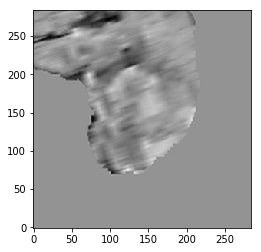

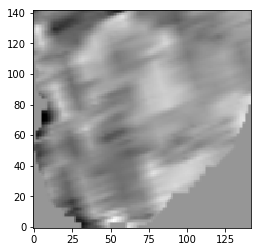

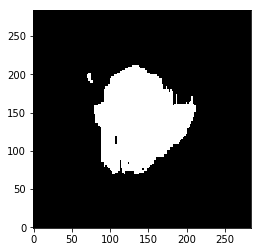

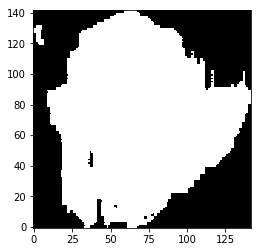

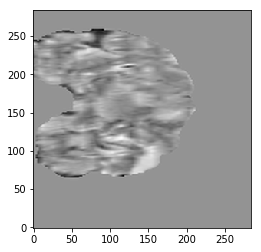

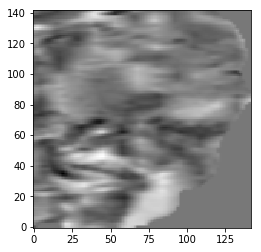

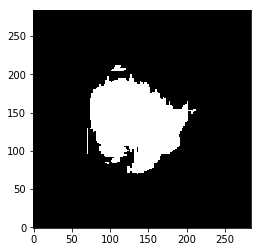

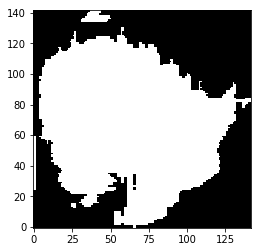

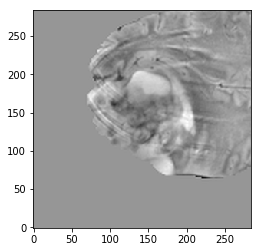

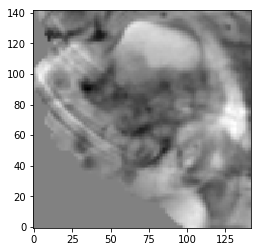

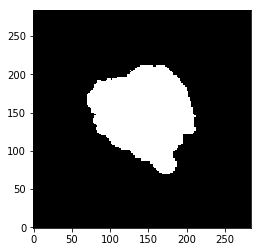

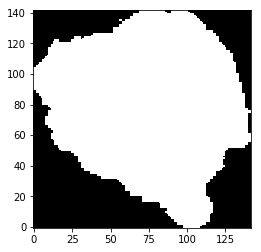

In [8]:


for dN in range(3):
    plt.imshow(exp_slice_dict['FLAIR'][260,:,:,dN], cmap="gray", origin="lower")
    plt.show()
    plt.imshow(slices_FLAIR_comb[260,:,:,dN], cmap="gray", origin="lower")
    plt.show()
    plt.imshow(exp_mask_arr[260,:,:,dN], cmap="gray", origin="lower")
    plt.clim(0,1)
    plt.show()
    plt.imshow(slices_mask_comb[260,:,:,dN], cmap="gray", origin="lower")
    plt.show()

In [9]:
# slice_num = 20 
# cv_num = 13

# for i in range(cv_num): # split between train and test 13 times

#     # assign indices for train,val, and test datasets in non-overlapping fashion
#     ind_test = range(i* slice_num, i*slice_num + slice_num)
#     if i == cv_num-1:
#         ind_val = range(0,slice_num)
#     else:
#         ind_val = range(i*slice_num + slice_num, i*slice_num + 2*slice_num)

#     ind_test_val = set(ind_test).union(set(ind_val))

#     ind_train = list(set(ind_test_val).symmetric_difference(ind_list))

#     # test data
#     ind_shuffled = shuffle(range(40))
#     print(ind_train)